In [2]:
import base64
import requests

# OpenAI API Key
with open("openai-key.txt", "r") as f:
    api_key = f.readline()

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

In [17]:
def generate(prompt, image_path, verbose = False):
    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode('utf-8')
    payload = {
      "model": "gpt-4-vision-preview",
      "messages": [
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}",
                  "detail": "low"
              }
            }
          ]
        }
      ],
      "max_tokens": 128
    }
    
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload).json()
    if verbose:
        from PIL import Image
        image = Image.open(image_path)
        display(image)
        print(response)
    if "usage" not in response and "error" in response:
        return {'prompt_tokens': 0, 'completion_tokens': 0, 'total_tokens': 0}, response["error"]["message"]
    return response["usage"], response["choices"][0]["message"]["content"]

generate("Describe this image", "images_split/20240101_172315_BUT.jpg")

({'prompt_tokens': 95, 'completion_tokens': 92, 'total_tokens': 187},
 'The image shows an illustration of a pair of human legs from the thigh down to the feet. It appears to represent someone walking or in mid-step, with one leg slightly ahead of the other, suggesting motion. The person is not wearing any shoes, and the backdrop is a simple, plain purple color, providing a contrast that highlights the legs. The style of the drawing is not highly detailed but uses clear lines and shapes to represent the form of the legs.')

  0%|                                                                                                                                                                  | 0/283 [00:00<?, ?it/s]

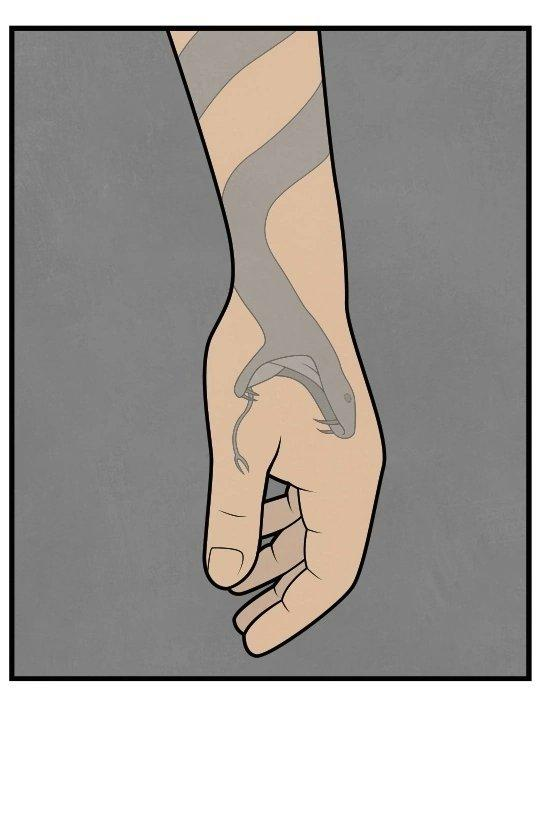

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 282/283 [00:01<00:00, 183.86it/s, current_usage=58476, total_usage=175966]

{'error': {'message': 'Your input image may contain content that is not allowed by our safety system.', 'type': 'invalid_request_error', 'param': None, 'code': 'content_policy_violation'}}


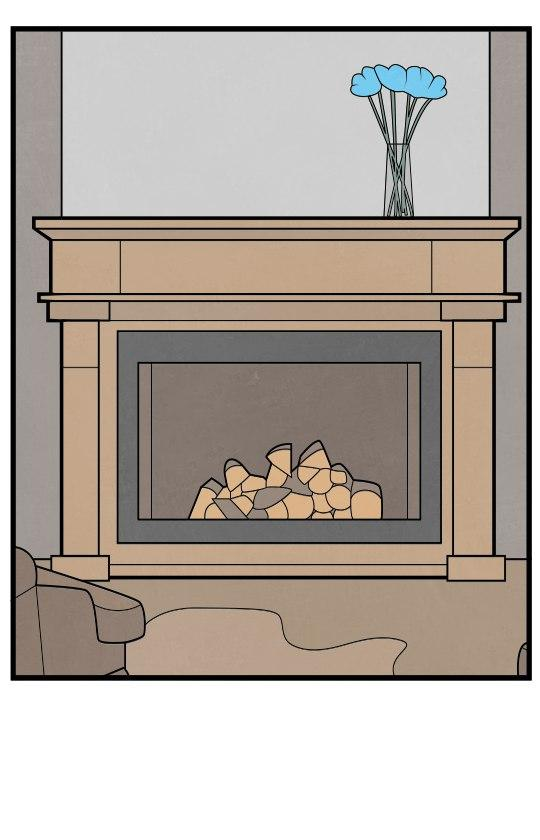

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:06<00:00, 44.06it/s, current_usage=58699, total_usage=176189]

{'id': 'chatcmpl-8i6MLGpxhJU6qENbKCTtzQsmyfK3A', 'object': 'chat.completion', 'created': 1705521569, 'model': 'gpt-4-1106-vision-preview', 'usage': {'prompt_tokens': 95, 'completion_tokens': 128, 'total_tokens': 223}, 'choices': [{'message': {'role': 'assistant', 'content': "The image shows a stylized representation of a room focusing on a fireplace. The fireplace has a classic design with a broad mantle and a rectangular firebox that appears to contain logs, suggesting it's either a wood-burning fireplace or a decorative simulation of one. Above the mantlepiece, there is an array of flowers, possibly blue carnations or similar, in a vase. The colors are muted, with primarily earth tones, giving the image a calm and warm ambiance. There is a partial view of what seems to be a couch or chair on the left side, and a rug or a piece of fabric on the floor in front of the"}, 'finish_reason': 'length', 'index': 0}]}


In [18]:
import os, json
from tqdm import tqdm

## schema [{"image_path": <>, "prompt": <>, "usage": {"prompt_tokens": ...}}]
with open("gpt4-usages.json", "r") as f:
    usages = json.load(f)
    total_usage = sum(x["usage"]["total_tokens"] for x in usages)


outpath = "outputs/left/gpt4-vision-left.json"
try:
    with open(outpath, "r") as f:
        outputs = json.load(f)
except Exception:
    print("starting from zero")
    outputs = []

current_usage = 58476
files = [x for x in os.listdir("images_split") if "YES" in x]
pbar = tqdm(files)
for filename in pbar:
    if filename in (o["image_path"] for o in outputs):
        continue
    prompt = "Describe this image"
    usage, output = generate(prompt, os.path.join("images_split", filename), True)

    outputs.append({"image_path":filename, "output": output})
    with open(outpath, "w") as f:
        json.dump(outputs, f, indent=2)

    usages.append({"image_path":filename, "prompt": prompt, "usage": usage})
    with open("gpt4-usages.json", "w") as f:
        json.dump(usages, f, indent=2)
    
    current_usage+=usage["total_tokens"]
    total_usage+=usage["total_tokens"]
    pbar.set_postfix({"current_usage": current_usage, "total_usage": total_usage})

    

In [ ]:
# whyfunny: 53930
# punchline: 63560
# left:
# right: 